In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv2D, GlobalMaxPooling1D, MaxPooling2D, Flatten, Dense, Input, Concatenate, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

## Purpose:

Takes a timezones tweets

Model Predicts state in either subregion or overall region

In [2]:
dfa = pd.read_csv('All_US_Time_tweets.csv')

In [3]:
#f = pd.read_csv('west_time_tweets.csv')
#df = pd.read_csv('central_time_tweets.csv')
#df = pd.read_csv('east_time_tweets.csv')
df = pd.read_csv('mountain_time_tweets.csv')

df.head()

,Timestamp,TweetText,Closest_State,Closest_City,Region,Timezone,Subtime
0,18385,should i be scared that just removed his belt,Arizona,Avenue B & C,Southwest,Mountain,South Mountain
1,28869,im craving a churro loco so bad right now,Arizona,Avenue B & C,Southwest,Mountain,South Mountain
2,66101,time to pretend mgmt,Arizona,Avenue B & C,Southwest,Mountain,South Mountain
3,74135,i hope i become a ghost the deadly syndrome,Arizona,Avenue B & C,Southwest,Mountain,South Mountain
4,61538,conan is going to have a live show on april 30...,Arizona,Avenue B & C,Southwest,Mountain,South Mountain


In [4]:
df.shape

(5966, 7)

In [5]:
print(df['Closest_State'].unique())
print(df['Subtime'].unique())

['Arizona' 'Colorado' 'Idaho' 'Montana' 'New Mexico' 'Utah' 'Wyoming']
['South Mountain' 'North Mountain']


In [6]:
df['TweetText'] = df['TweetText'].astype(str)
dfa['TweetText'] = dfa['TweetText'].astype(str)

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dfa['TweetText'].tolist())

In [8]:
df2 = df.copy()

In [9]:
cols = ['Closest_City','Region']
df2 = df2.drop(cols, axis = 1)

In [10]:
one_hot = pd.get_dummies(df2['Subtime'])
df2 = df2.join(one_hot)
df2 = df2.drop('Subtime', axis = 1)

In [11]:
df2.head()

,Timestamp,TweetText,Closest_State,Timezone,North Mountain,South Mountain
0,18385,should i be scared that just removed his belt,Arizona,Mountain,False,True
1,28869,im craving a churro loco so bad right now,Arizona,Mountain,False,True
2,66101,time to pretend mgmt,Arizona,Mountain,False,True
3,74135,i hope i become a ghost the deadly syndrome,Arizona,Mountain,False,True
4,61538,conan is going to have a live show on april 30...,Arizona,Mountain,False,True


In [12]:
x_dat = df2[['TweetText','Timestamp']]
y_dat = df2[df['Subtime'].unique()]

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_dat, y_dat, test_size = 0.25, random_state = 40)

In [14]:
x_dat["TweetText"].str.split(" ").str.len().describe(percentiles=[0.01, 0.5, 0.99])

count    5966.000000
mean       12.179350
std         7.086652
min         1.000000
1%          2.000000
50%        11.000000
99%        29.000000
max        36.000000
Name: TweetText, dtype: float64

In [15]:
tmax_length = 29

In [16]:
train_sequences = tokenizer.texts_to_sequences(x_train['TweetText'].tolist())
test_sequences = tokenizer.texts_to_sequences(x_test['TweetText'].tolist())

train_seq = pad_sequences(train_sequences, maxlen = tmax_length, padding = 'post', truncating = 'post')
test_seq = pad_sequences(test_sequences, maxlen = tmax_length, padding = 'post', truncating = 'post')

In [17]:
vocab_size = len(tokenizer.index_word) + 1
embedding_dim = 150

In [18]:
timestamps_train = x_train['Timestamp']
timestamps_test = x_test['Timestamp']

In [21]:
input_seq = Input(shape = (tmax_length,), name = 'Input Sequence')
input_time = Input(shape = (1,), name = "Input Timestamp")

embed = Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = tmax_length)(input_seq)
convol = Conv1D(filters = 128, kernel_size = 3, activation = 'relu')(embed)
maxpool = GlobalAveragePooling1D()(convol)

concat = Concatenate()([maxpool, input_time])
dense1 = Dense(50, activation = 'relu')(concat)
dense2 = Dense(25, activation = 'relu')(dense1)
dense3 = Dense(15, activation = 'relu')(dense2)
output = Dense(len(df['Subtime'].unique()), activation = 'sigmoid')(dense3)

model = Model(inputs = [input_seq, input_time], outputs = output)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['f1_score'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input Sequence      │ (None, 29)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 29, 150)   │ 27,806,850 │ Input             │
│ (Embedding)         │                   │            │ Sequence[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 27, 128)   │     57,728 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input Timestamp     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 129)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ Input             │
│                     │                   │            │ Timestamp[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 50)        │      6,500 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 25)        │      1,275 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 15)        │        390 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 2)         │         32 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,872,775 (106.33 MB)

 Trainable params: 27,872,775 (106.33 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history = model.fit([train_seq, timestamps_train], y_train, epochs = 6, batch_size = 50, validation_data = ([test_seq, timestamps_test], y_test))

Epoch 1/6
90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - accuracy: 0.8938 - loss: 22.5661 - val_accuracy: 0.9564 - val_loss: 0.2787
Epoch 2/6
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 0.9379 - loss: 0.6602 - val_accuracy: 0.9564 - val_loss: 0.4354
Epoch 3/6
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.9418 - loss: 0.3617 - val_accuracy: 0.9564 - val_loss: 0.8461
Epoch 4/6
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - accuracy: 0.9075 - loss: 3.3890 - val_accuracy: 0.9564 - val_loss: 0.4043
Epoch 5/6
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 0.9536 - loss: 0.3970 - val_accuracy: 0.9564 - val_loss: 0.2922
Epoch 6/6
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 0.9574 - loss: 0.2948 - val_accuracy: 0.9564 - val_loss: 0.2263


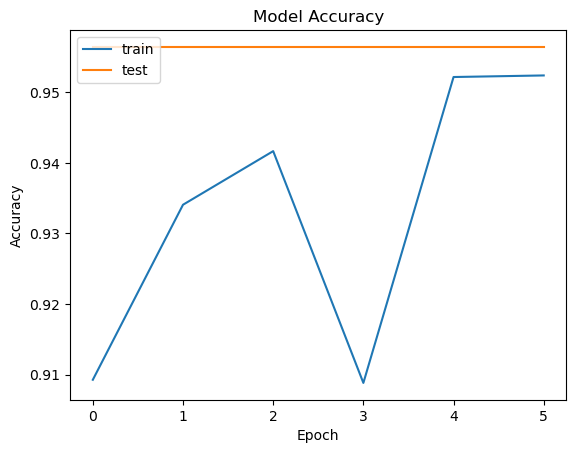

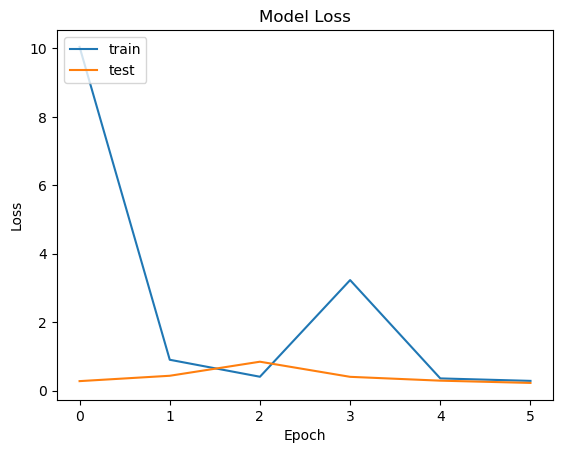

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()